# Running PVAnalytics QA Routines on Temperature Data

Import all of the necessary packages for running QA.

In [1]:
import pandas as pd
import glob
import timezonefinder
from statistics import mode
import numpy as np
from matplotlib import pyplot as plt
import rdtools
import pvanalytics
from pvanalytics.quality import data_shifts as ds
from pvanalytics.quality import gaps
from pvanalytics.quality.outliers import zscore
from pvanalytics.features.daytime import power_or_irradiance
from pvanalytics.system import is_tracking_envelope
import pva_time_shifts as tsh

## Temperature Data

The code below can be used to run a variation of the PV Fleets (https://www.nrel.gov/pv/fleet-performance-data-initiative.html) QA routine on a measured temperature stream.

First, define time series CSV, and associated system latitude-longitude coordinates. Latitude-longitude coordinates will be used to model solar output at the specified location using pvlib functionality.

In [2]:
file_path = "./data/system_4_module_temperature.csv"
latitude = 39.7406
longitude = -105.1774
# Identify the temperature data stream type (this affects the type of checks we do)
data_stream_type = "module"

# Read in the file as as pandas series
time_series = pd.read_csv(file_path, parse_dates=True, index_col=0).squeeze()

# Remove any duplicate index values (this is just a failsafe in case there are!)
time_series = time_series.groupby(time_series.index).first()

Get the associated data sampling frequency of the time series.

In [3]:
# Show the time series just to check it's timezone-aware. This is important for all future analysis, as many
# PVAnalytics functions require tz-aware data.

print(time_series)

# Get the time series frequency
freq_minutes = int((mode(abs(np.diff(time_series.index)))).total_seconds() / 60)
data_freq = str(freq_minutes) + "T"

2007-08-25 17:00:00-07:00    21.58800
2007-08-25 17:15:00-07:00    21.97200
2007-08-25 17:30:00-07:00    21.92000
2007-08-25 17:45:00-07:00    22.01300
2007-08-25 18:00:00-07:00    21.41400
                               ...   
2023-09-29 14:00:00-07:00    15.80904
2023-09-29 14:15:00-07:00    14.18414
2023-09-29 14:30:00-07:00    13.17503
2023-09-29 14:45:00-07:00    12.64178
2023-09-29 15:00:00-07:00    12.58730
Name: module_temp_1, Length: 564377, dtype: float64


## Visualize Original Time Series

Visualize the starting time series as reference.

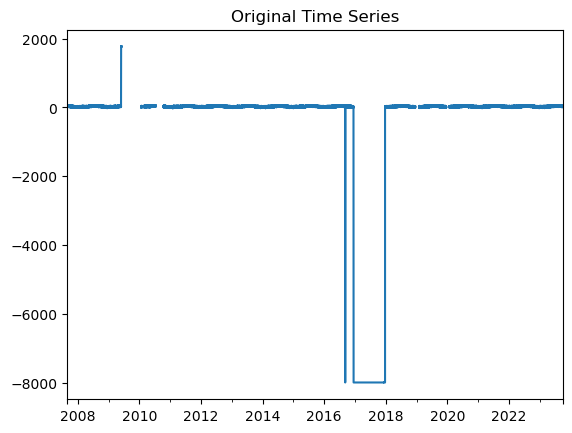

In [4]:
time_series.plot(title="Original Time Series")
plt.show()
plt.close()

## Run Basic Data Checks: Stale and Abnormal Data

Basic data checks include removing the following:
1) Flatlined/stale data periods (https://pvanalytics.readthedocs.io/en/stable/generated/gallery/gaps/stale-data.html#sphx-glr-generated-gallery-gaps-stale-data-py)

2) "Abnormal" data periods, which are out of the temperature limits of -40 to 185 deg C. Additional checks based on thresholds are applied depending on the type of temperature sensor (ambient or module)

3) Outliers, which are defined as more than one 4 standard deviations away from the mean (https://pvanalytics.readthedocs.io/en/stable/generated/gallery/outliers/zscore-outlier-detection.html#sphx-glr-generated-gallery-outliers-zscore-outlier-detection-py)

Estimated Temperature units: C


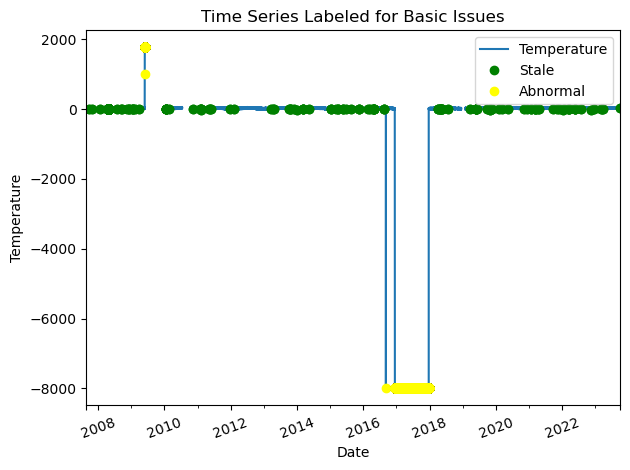

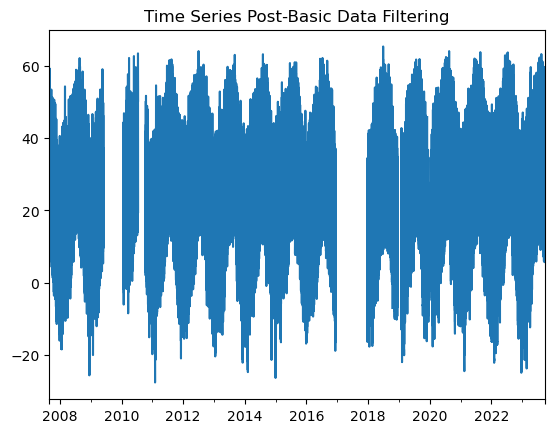

In [5]:
# REMOVE STALE DATA
# Stale data mask
stale_data_mask = gaps.stale_values_round(time_series,
                                          window=3,
                                          decimals=2)

# FIND ABNORMAL PERIODS
temperature_limit_mask = pvanalytics.quality.weather.temperature_limits(time_series,
                                                                        limits=(-40, 185))
temperature_limit_mask = temperature_limit_mask.reindex(index=time_series.index,
                                                        method='ffill',
                                                        fill_value=False)

# FIND OUTLIERS (Z-SCORE FILTER)
zscore_outlier_mask = zscore(time_series,
                             zmax=4,
                             nan_policy='omit')

# PERFORM ADDITIONAL CHECKS, INCLUDING CHECKING UNITS (CELSIUS OR FAHRENHEIT)
temperature_mean = time_series.mean()
if temperature_mean > 35:
    temp_units = 'F'
else:
    temp_units = 'C'

print("Estimated Temperature units: " + str(temp_units))

# Run additional checks based on temperature sensor type.
if data_stream_type == 'module':
    if temp_units == 'C':
        module_limit_mask = (time_series <= 85)
        temperature_limit_mask = (temperature_limit_mask & module_limit_mask)
if data_stream_type == 'ambient':
    ambient_limit_mask = pvanalytics.quality.weather.temperature_limits(
            time_series, limits=(-40, 120))
    temperature_limit_mask = (temperature_limit_mask & ambient_limit_mask)
    if temp_units == 'C':
        ambient_limit_mask_2 = (time_series <= 50)
        temperature_limit_mask = (temperature_limit_mask & ambient_limit_mask_2)
# Get the percentage of data flagged for each issue, so it can later be logged
pct_stale = round((len(time_series[stale_data_mask].dropna())/len(time_series.dropna())*100), 1)
pct_erroneous = round((len(time_series[~temperature_limit_mask].dropna())/len(time_series.dropna())*100), 1)
pct_outlier = round((len(time_series[zscore_outlier_mask].dropna())/len(time_series.dropna())*100), 1)

# Visualize all of the time series issues (stale, abnormal, outlier, etc)
time_series.plot()
labels = ["Temperature"]
if any(stale_data_mask):
    time_series.loc[stale_data_mask].plot(ls='', marker='o', color = "green")
    labels.append("Stale")
if any(~temperature_limit_mask):
    time_series.loc[~temperature_limit_mask].plot(ls='', marker='o', color = "yellow")
    labels.append("Abnormal")
if any(zscore_outlier_mask):
    time_series.loc[zscore_outlier_mask].plot(ls='', marker='o', color = "purple")
    labels.append("Outlier")
plt.legend(labels=labels)
plt.title("Time Series Labeled for Basic Issues")
plt.xticks(rotation=20)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()
plt.close()

# Filter the time series, taking out all of the issues
time_series = time_series[~stale_data_mask]
time_series = time_series[temperature_limit_mask]
time_series = time_series[~zscore_outlier_mask]
time_series = time_series.asfreq(data_freq)

# Visualize the time series post-filtering
time_series.plot(title = "Time Series Post-Basic Data Filtering")
plt.show()
plt.close()

## Filter by Completeness Score
Filter the time series by a daily "completeness" score (https://pvanalytics.readthedocs.io/en/stable/generated/gallery/gaps/data-completeness.html#sphx-glr-generated-gallery-gaps-data-completeness-py).This filtering scheme requires at least 25% of data to be present for each day for it to be included. We further require that there be at least 10 consecutive days meeting this 25% threshold for the day to be included (see https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.quality.gaps.trim_incomplete.html#pvanalytics.quality.gaps.trim_incomplete for more info).

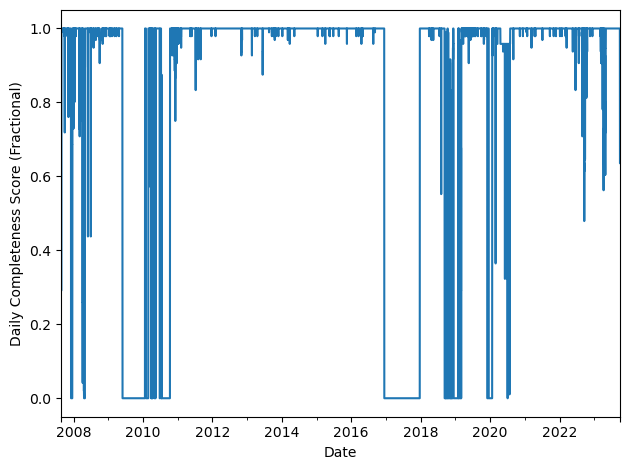

C:\ProgramData\Anaconda3\envs\pvfleets_qa_analysis\lib\site-packages\pvanalytics\quality\gaps.py:413: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  mask.loc[start.date():end.date()] = True


In [6]:
# Visualize daily data completeness
data_completeness_score = gaps.completeness_score(time_series)

# Visualize data completeness score as a time series.
data_completeness_score.plot()
plt.xlabel("Date")
plt.ylabel("Daily Completeness Score (Fractional)")
plt.tight_layout()
plt.show()

# Trim the series based on daily completeness score
trim_series = pvanalytics.quality.gaps.trim_incomplete(time_series,
                                                       minimum_completeness=.25,
                                                       freq=data_freq)
first_valid_date, last_valid_date = pvanalytics.quality.gaps.start_stop_dates(trim_series)
time_series = time_series[first_valid_date.tz_convert(time_series.index.tz):last_valid_date.tz_convert(time_series.index.tz)]
time_series = time_series.asfreq(data_freq)

## Determine Data Shifts

Examine the daily time series for abrupt capacity shifts, and determine the longest continuous part of the series free of data shifts. Once again, changepoint detection is used to determine shift dates.

Shift Found??
False


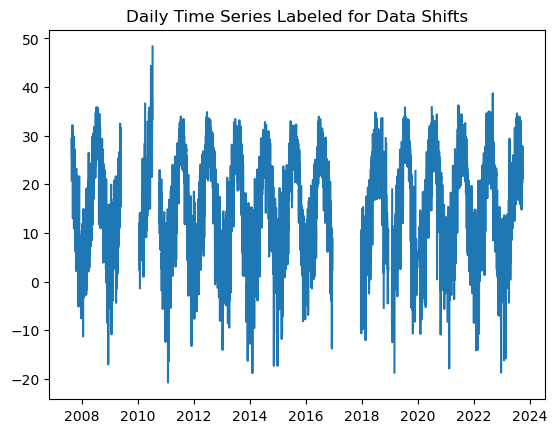

In [7]:
# Resample the time series to daily mean
time_series_daily = time_series.resample('D').mean()
data_shift_start_date, data_shift_end_date = \
            ds.get_longest_shift_segment_dates(time_series_daily)
data_shift_period_length = (data_shift_end_date - data_shift_start_date).days

# Get the number of shift dates
data_shift_mask = pvanalytics.quality.data_shifts.detect_data_shifts(time_series_daily)
# Get the shift dates
shift_dates = list(time_series_daily[data_shift_mask].index)
if len(shift_dates) > 0:            
    shift_found = True
else:
    shift_found = False

# Visualize the time shifts for the daily time series
print("Shift Found??")
print(shift_found)
edges = [time_series_daily.index[0]] + shift_dates + [time_series_daily.index[-1]]
fig, ax = plt.subplots()
for (st, ed) in zip(edges[:-1], edges[1:]):
    ax.plot(time_series_daily.loc[st:ed])
plt.title("Daily Time Series Labeled for Data Shifts")
plt.show()
plt.close()

In [8]:
# Filter the time series to only include the longest shift-free period
time_series = time_series[(time_series.index >= data_shift_start_date.tz_convert(time_series.index.tz)) &
                          (time_series.index <= data_shift_end_date.tz_convert(time_series.index.tz))]

time_series = time_series.asfreq(data_freq)

## Display the final filtered time series

Show the final time series post-processing as reference.

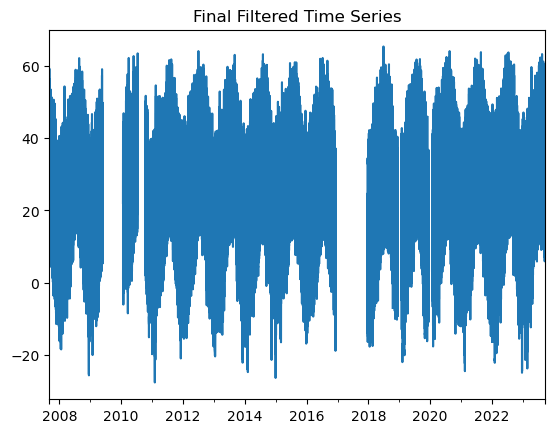

In [9]:
time_series.plot(title="Final Filtered Time Series")
plt.show()
plt.close()

## Generate QA Report

Generate a dictionary outlining all of the different issues present for the time series.

In [11]:
qa_check_dict = {"pct_stale": pct_stale,
                 "pct_erroneous": pct_erroneous,
                 "pct_outlier": pct_outlier,
                 "data_shifts": shift_found,
                 "shift_dates": shift_dates,
                 "filtered_time_series": time_series}

print("QA Results:")
print(qa_check_dict)

QA Results:
{'pct_stale': 7.2, 'pct_erroneous': 6.9, 'pct_outlier': 0.0, 'data_shifts': False, 'shift_dates': [], 'filtered_time_series': 2007-09-01 00:00:00-07:00    26.08300
2007-09-01 00:15:00-07:00    25.77300
2007-09-01 00:30:00-07:00    25.42900
2007-09-01 00:45:00-07:00    28.86600
2007-09-01 01:00:00-07:00    29.55300
                               ...   
2023-09-20 23:00:00-07:00    10.08242
2023-09-20 23:15:00-07:00    10.39229
2023-09-20 23:30:00-07:00    11.63274
2023-09-20 23:45:00-07:00    12.76597
2023-09-21 00:00:00-07:00    12.47282
Freq: 15T, Name: module_temp_1, Length: 562945, dtype: float64}
